# Libraries import

In [71]:
!pip3 install spacy
!pip3 install gensim
!pip3 install pyLDAvis
!pip3 install --upgrade ipykernel
!pip3 install wordcloud
!pip3 install shap
!pip3 install textblob

     |████████████████████████████████| 636 kB 9.7 MB/s            
You should consider upgrading via the '/Users/yopa/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [72]:
import spacy
#spacy.load('en_core_web_sm')
from spacy.lang.en import English
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from gensim import corpora
import pickle
import gensim
import pyLDAvis.gensim_models
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import shap
from textblob import TextBlob

shap.initjs()

[nltk_data] Downloading package wordnet to /Users/yopa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1- Topic Modeling

## Overall Text Cleaning pipeline

In [24]:
class ReviewsPreprocess:
    # CLass to tokenize reviews
    
    def __init__(self, dataframe, targetColumn):
        """ 
        Parameters:
        -----------
        dataframe: pandas dataframe
            Dataframe with the reviews and other infos
        targetColumn: string
            name of the column containing the reviews
        """
        self.reviews_ = []
        self.df_ = dataframe
        self.reviewColumn_ = targetColumn
        
    
    def preprocess(self, minWordLength):
        """ Convert each review into list of tokens
        Parameters:
        -----------
        minWordLength: integer
            minimum length of token
        """
        
        # Clean the reviews and return list of tokens
        parser = English()
        def tokenize(text):
            lda_tokens = []
            tokens = parser(text)
            for token in tokens:
                if token.orth_.isspace():
                    continue
                elif token.like_url:
                    lda_tokens.append('URL')
                elif token.orth_.startswith('@'):
                    lda_tokens.append('SCREEN_NAME')
                else:
                    lda_tokens.append(token.lower_)
            return lda_tokens
        
        # Get root of words
        def get_lemma(word):
            return WordNetLemmatizer().lemmatize(word)
        
        # Filter out stopwords
        nltk.download('stopwords')
        en_fr_stop = set(nltk.corpus.stopwords.words('english')).union(set(nltk.corpus.stopwords.words('french')))
        
        
        ### Do the preprocess steps ###########
        for review in self.df_[self.reviewColumn_]:
            tokens = tokenize(review)
            tokens = [token for token in tokens if len(token) > minWordLength]
            tokens = [token for token in tokens if token not in en_fr_stop]
            tokens = [get_lemma(token) for token in tokens]
            
            self.reviews_.append(tokens)
            
        # Add the preprocessed review as a column in the dataframe
        self.df_['tokens'] = self.reviews_
                

In [4]:
# Test object
df = pd.read_csv('tripadvisor_consolidated3.csv')               

In [5]:
df.head()

,Unnamed: 0,title,date,rating,review,airline
0,0,Absolutely terrible on all counts,Date of travel: January 2022,ui_bubble_rating bubble_10,"b'Slow, rude service from appalling, lazy and ...",Ryanair
1,1,Family plus package,Date of travel: February 2022,ui_bubble_rating bubble_10,b'Please be careful of this package family of ...,Ryanair
2,2,Bournemouth staff,Date of travel: February 2022,ui_bubble_rating bubble_10,b'Forgot to do the locator form and the girls ...,Ryanair
3,3,Sneaky and cheap,Date of travel: February 2022,ui_bubble_rating bubble_10,b'This is my first ever review but I am so dis...,Ryanair
4,4,The trip changed my opinion 5 star crew,Date of travel: February 2022,ui_bubble_rating bubble_10,"b""I won't lie, I can write about million thing...",Ryanair


In [6]:
# Remove first two characters in review column
df['review'] = df['review'].apply(lambda x: x[2:])

In [7]:
df.head()

,Unnamed: 0,title,date,rating,review,airline
0,0,Absolutely terrible on all counts,Date of travel: January 2022,ui_bubble_rating bubble_10,"Slow, rude service from appalling, lazy and ug...",Ryanair
1,1,Family plus package,Date of travel: February 2022,ui_bubble_rating bubble_10,Please be careful of this package family of 4 ...,Ryanair
2,2,Bournemouth staff,Date of travel: February 2022,ui_bubble_rating bubble_10,Forgot to do the locator form and the girls at...,Ryanair
3,3,Sneaky and cheap,Date of travel: February 2022,ui_bubble_rating bubble_10,This is my first ever review but I am so disap...,Ryanair
4,4,The trip changed my opinion 5 star crew,Date of travel: February 2022,ui_bubble_rating bubble_10,"I won't lie, I can write about million things ...",Ryanair


In [25]:
text = ReviewsPreprocess(df, 'review')

In [26]:
text.preprocess(minWordLength=3)

[nltk_data] Downloading package stopwords to /Users/yopa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
text.df_.tokens[0]

['slow',
 'rude',
 'service',
 'appalling',
 'lazy',
 'ugly',
 'staff',
 'rammed',
 'like',
 'sardine',
 'delayed',
 'hour',
 'lost',
 'bag',
 'compensation']

In [28]:
print(len(text.reviews_))

7885


## Topics extraction

In [29]:
dictionary = corpora.Dictionary(text.reviews_)
corpus = [dictionary.doc2bow(text) for text in text.reviews_]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [30]:
print(dictionary)

Dictionary(19109 unique tokens: ['appalling', 'bag', 'compensation', 'delayed', 'hour']...)


In [39]:
NUM_TOPICS = 10 # chose number of topics to extract
NUM_WORDS=10 # chose number of words to characterize each toic

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=NUM_WORDS)
#for topic in topics:
#    print(topic)
#    print('')

/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [32]:
few_reviews = corpus[:10]
for i, review in enumerate(few_reviews):
    print(ldamodel[review])
    print(text.df_['review'][i])
    print('')

# topic number and probability to belonging to this topic + associated review

[(0, 0.95253104), (1, 0.026396276), (2, 0.02107272)]
Slow, rude service from appalling, lazy and ugly staff.  Rammed in like sardines  Delayed by 2 hours  Lost 1 of my bags and no compensation'

[(0, 0.84833413), (1, 0.14342636)]
Please be careful of this package family of 4 baggage allowance is 1 x 20 kilo bag 3x 10kilos bags  To go straight to the point this is not enough for 2 week holiday tried to upgrade to plus but not not allowed instead I had to buy 2 x 20 kilos bags for an extra 214 pounds  Make sure you fully understand the packages before booking as once you book no way of changing  RYANAIR THIS IS THE LAST TIME , YOU WILL NEVER SEE A PENNY FROM ME WOULD RATHER NOT GO ON HOLIDAY THAN GIVE MY HARD EARNED MONEY TO YOU'

[(0, 0.7225446), (1, 0.2516085), (2, 0.025846858)]
Forgot to do the locator form and the girls at the desk in Bournemouth were absolutely fantastic in helping me filling it out in a hurry. Thank you'

[(0, 0.9475004), (1, 0.04731756)]
This is my first ever revi

## Vizualize topics extracted

In [40]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')

In [41]:
lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Assign each review to its topics

In [42]:
reviews_labelled = text.df_  # dataframe with rewiews and their corresponding tokens
topic_distribution = []
NUM_TOPICS = 10

# Loop through the reviews in 'bag of words' form
for review_bow in corpus:
    
    # Get topic distribution of the review
    topics = lda.get_document_topics(review_bow)
    topics_mapped = [0]*NUM_TOPICS
    for pair in topics:
        topics_mapped[pair[0]] = pair[1]
    topic_distribution.append(topics_mapped)
    

In [43]:
print(topic_distribution[:10])

[[0, 0.22117238, 0, 0.61991596, 0, 0, 0, 0.11511015, 0, 0], [0.9795325, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.57703155, 0.36136597, 0, 0, 0, 0, 0, 0], [0.29667833, 0, 0, 0, 0.10886323, 0, 0, 0, 0, 0.5835165], [0, 0.20820083, 0, 0.106278725, 0.18072276, 0, 0, 0.25327697, 0, 0.24833082], [0.10731378, 0.11462857, 0, 0.6128813, 0, 0, 0, 0, 0, 0.14447823], [0.101006754, 0, 0, 0, 0, 0, 0, 0, 0, 0.8808031], [0.3478677, 0, 0, 0.21477363, 0, 0, 0, 0, 0, 0.40535825], [0, 0.032600712, 0, 0, 0.04778121, 0, 0, 0, 0, 0.9015785], [0.31367022, 0, 0, 0, 0.5726809, 0, 0, 0, 0, 0.09453016]]


In [44]:
## Add per review topic distribution to dataframe

# Get a list of shape nb reviews * nb of topics
topic_distribution_transposed = list(np.array(topic_distribution).T)

# Add topics to data frame
for i, column in enumerate(topic_distribution_transposed):
    col_name = 'topic_'+str(i+1)
    reviews_labelled[col_name] = topic_distribution_transposed[i]
    

In [45]:
reviews_labelled.head()

,Unnamed: 0,title,date,rating,review,airline,tokens,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0,Absolutely terrible on all counts,Date of travel: January 2022,ui_bubble_rating bubble_10,"Slow, rude service from appalling, lazy and ug...",Ryanair,"[slow, rude, service, appalling, lazy, ugly, s...",0.000000,0.221172,0.000000,0.619916,0.000000,0.0,0.0,0.115110,0.0,0.000000
1,1,Family plus package,Date of travel: February 2022,ui_bubble_rating bubble_10,Please be careful of this package family of 4 ...,Ryanair,"[please, careful, package, family, baggage, al...",0.979532,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,2,Bournemouth staff,Date of travel: February 2022,ui_bubble_rating bubble_10,Forgot to do the locator form and the girls at...,Ryanair,"[forgot, locator, form, girl, desk, bournemout...",0.000000,0.000000,0.577032,0.361366,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,3,Sneaky and cheap,Date of travel: February 2022,ui_bubble_rating bubble_10,This is my first ever review but I am so disap...,Ryanair,"[first, ever, review, disappointed, ryanair, n...",0.296678,0.000000,0.000000,0.000000,0.108863,0.0,0.0,0.000000,0.0,0.583516
4,4,The trip changed my opinion 5 star crew,Date of travel: February 2022,ui_bubble_rating bubble_10,"I won't lie, I can write about million things ...",Ryanair,"[write, million, thing, ryan, could, improve, ...",0.000000,0.208201,0.000000,0.106279,0.180723,0.0,0.0,0.253277,0.0,0.248331


# 2- Insights 

## Filter out reviews

In [46]:
# List of topics in our scope
topics_in_scope = [1, 2, 4, 5, 9]  # took the topics related to the word 'seat' & 'plane'
topics_in_scope = ['topic_'+str(num) for num in topics_in_scope]
print(topics_in_scope)

['topic_1', 'topic_2', 'topic_4', 'topic_5', 'topic_9']


In [47]:
# Add sum of probability of topics in scope in our dataframe
reviews_labelled['topics_in_scope'] = 0
for topic in topics_in_scope:
    reviews_labelled['topics_in_scope'] += reviews_labelled[topic]

In [48]:
reviews_labelled.head()

,Unnamed: 0,title,date,rating,review,airline,tokens,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topics_in_scope
0,0,Absolutely terrible on all counts,Date of travel: January 2022,ui_bubble_rating bubble_10,"Slow, rude service from appalling, lazy and ug...",Ryanair,"[slow, rude, service, appalling, lazy, ugly, s...",0.000000,0.221172,0.000000,0.619916,0.000000,0.0,0.0,0.115110,0.0,0.000000,0.841088
1,1,Family plus package,Date of travel: February 2022,ui_bubble_rating bubble_10,Please be careful of this package family of 4 ...,Ryanair,"[please, careful, package, family, baggage, al...",0.979532,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.979532
2,2,Bournemouth staff,Date of travel: February 2022,ui_bubble_rating bubble_10,Forgot to do the locator form and the girls at...,Ryanair,"[forgot, locator, form, girl, desk, bournemout...",0.000000,0.000000,0.577032,0.361366,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.361366
3,3,Sneaky and cheap,Date of travel: February 2022,ui_bubble_rating bubble_10,This is my first ever review but I am so disap...,Ryanair,"[first, ever, review, disappointed, ryanair, n...",0.296678,0.000000,0.000000,0.000000,0.108863,0.0,0.0,0.000000,0.0,0.583516,0.405542
4,4,The trip changed my opinion 5 star crew,Date of travel: February 2022,ui_bubble_rating bubble_10,"I won't lie, I can write about million things ...",Ryanair,"[write, million, thing, ryan, could, improve, ...",0.000000,0.208201,0.000000,0.106279,0.180723,0.0,0.0,0.253277,0.0,0.248331,0.495202


/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yopa/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


<AxesSubplot:xlabel='topics_in_scope', ylabel='Count'>

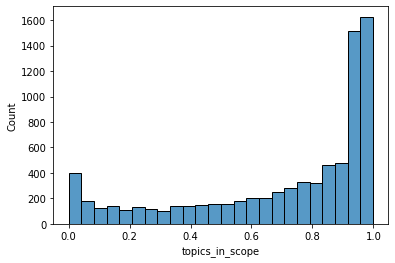

In [49]:
sns.histplot(data=reviews_labelled, x='topics_in_scope')

In [52]:
threshold = 0.8
reviews_labelled.loc[reviews_labelled['topics_in_scope']>threshold, ["review"]].head(10).values

# looks ok : most of reviews are somehow related to cabin/seats

array([["Slow, rude service from appalling, lazy and ugly staff.  Rammed in like sardines  Delayed by 2 hours  Lost 1 of my bags and no compensation'"],
       ["Please be careful of this package family of 4 baggage allowance is 1 x 20 kilo bag 3x 10kilos bags  To go straight to the point this is not enough for 2 week holiday tried to upgrade to plus but not not allowed instead I had to buy 2 x 20 kilos bags for an extra 214 pounds  Make sure you fully understand the packages before booking as once you book no way of changing  RYANAIR THIS IS THE LAST TIME , YOU WILL NEVER SEE A PENNY FROM ME WOULD RATHER NOT GO ON HOLIDAY THAN GIVE MY HARD EARNED MONEY TO YOU'"],
       ["Shocking customer service on the check in desk. The young women was so rude and unhelpful. Telling me and my partner to get to the back of the queue after 40 minutes in the check in queue because she didnt want to serve people just yet. Eventually she served us and purposely sat us away from each other on the plane. 

## Word clouds

In [53]:
corpus[1]

[(1, 2),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 2),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 2),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1)]

In [59]:
plt.rcParams["figure.figsize"] = [16, 9]

def create_ngrams(token_list, nb_elements, stop_words=None):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    token_list : list
        list of strings
    nb_elements :
        number of elements in the n-gram
    Returns
    -------
    Generator
        generator of all n-grams
    """
    if stop_words is not None:
        token_list = [token for token in token_list if token not in stop_words]
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    
    return list(" ".join(ngram) for ngram in ngrams)
    

def make_word_cloud(reviews_token, stop_words=None, ngrams_number=1, number_top_words=10):
    
    list_ngrams = []
    for review in reviews_token:
        ngram = create_ngrams(review, nb_elements=ngrams_number, stop_words=stop_words)
        list_ngrams += ngram
    
    counter = Counter(list_ngrams)
        
    word_cloud = wordcloud.WordCloud(stopwords=None).generate_from_frequencies(counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
    print(counter.most_common(number_top_words))
  

In [64]:
Counter(create_ngrams(reviews_labelled.tokens[10], 1))

Counter({'stay': 1,
         'away': 1,
         'airline': 2,
         'company': 2,
         'possible': 1,
         'flight': 1,
         'seem': 1,
         'appealing': 1,
         'price': 1,
         'charging': 1,
         'triple': 1,
         'comparison': 1,
         'competing': 1,
         'want': 1,
         'trip': 1,
         'mood': 1,
         'ruined': 1,
         'staff': 1,
         'disgusting': 1,
         'never': 1,
         'mind': 1,
         'customer': 1,
         'service': 1,
         'even': 1,
         'basic': 1,
         'manner': 1})

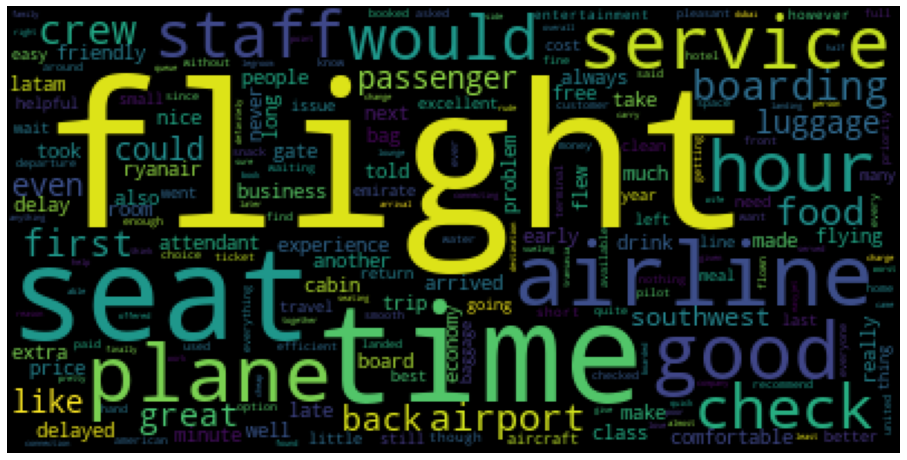

[('flight', 6896), ('time', 2516), ('seat', 2217), ('airline', 1967), ('plane', 1692), ('good', 1635), ('service', 1494), ('hour', 1407), ('staff', 1185), ('would', 1102)]


In [66]:
make_word_cloud(reviews_labelled.loc[reviews_labelled['topics_in_scope']>0.8].tokens)

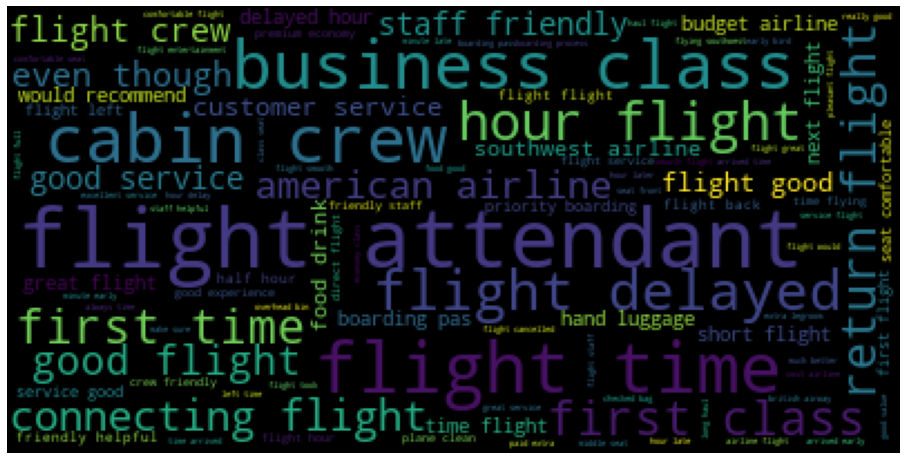

[('flight attendant', 400), ('flight time', 292), ('business class', 279), ('cabin crew', 276), ('flight delayed', 222), ('hour flight', 213), ('first class', 166), ('return flight', 161), ('first time', 159), ('connecting flight', 154)]


In [67]:
make_word_cloud(reviews_labelled.loc[reviews_labelled['topics_in_scope']>0.8].tokens, ngrams_number=2)

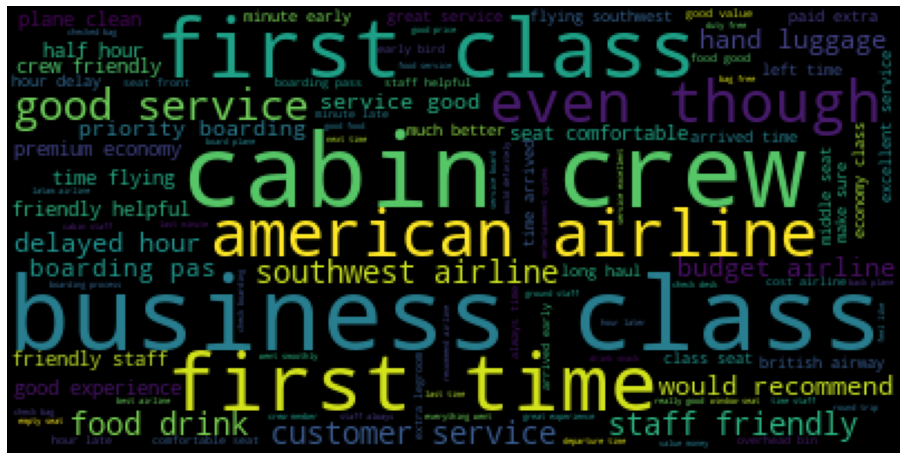

[('business class', 279), ('cabin crew', 276), ('first class', 166), ('first time', 159), ('american airline', 136), ('even though', 115), ('good service', 115), ('staff friendly', 115), ('customer service', 111), ('southwest airline', 105)]


In [68]:
make_word_cloud(reviews_labelled.loc[reviews_labelled['topics_in_scope']>0.8].tokens, ngrams_number=2, stop_words=['flight'])

## Sentiment Analysis - Draft

In [95]:
corpus,y = shap.datasets.imdb()
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [96]:
corpus

["Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n",
 "Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & her so

In [97]:
y

array([False, False, False, ...,  True,  True,  True])

In [99]:
X_train[:2, :2]

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

## Sentiment Analysis

In [69]:
# Add colunm with preprocessed reviews
reviews_labelled['preprocessed_review'] = [' '.join(token) for token in reviews_labelled['tokens']]

In [70]:
reviews_labelled['preprocessed_review'].head()

0    slow rude service appalling lazy ugly staff ra...
1    please careful package family baggage allowanc...
2    forgot locator form girl desk bournemouth abso...
3    first ever review disappointed ryanair needed ...
4    write million thing ryan could improve honest ...
Name: preprocessed_review, dtype: object

In [86]:
# Get sentiment of each review
df_sentiment =  reviews_labelled.loc[reviews_labelled['topics_in_scope']>0.8,
                                     ['title', 'preprocessed_review', 'tokens']]

df_sentiment['sentiment'] = [TextBlob(str(text)).sentiment.polarity for text in df_sentiment.preprocessed_review]

df_sentiment.head()



,title,preprocessed_review,tokens,sentiment
0,Absolutely terrible on all counts,slow rude service appalling lazy ugly staff ra...,"[slow, rude, service, appalling, lazy, ugly, s...",-0.380000
1,Family plus package,please careful package family baggage allowanc...,"[please, careful, package, family, baggage, al...",0.044048
5,Shocking service,shocking customer service check desk young wom...,"[shocking, customer, service, check, desk, you...",-0.300000
9,mrs,ryanair charged euro half airplain check work ...,"[ryanair, charged, euro, half, airplain, check...",0.070000
14,Good experience,cost company thing improved overall pleasant,"[cost, company, thing, improved, overall, plea...",0.366667


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

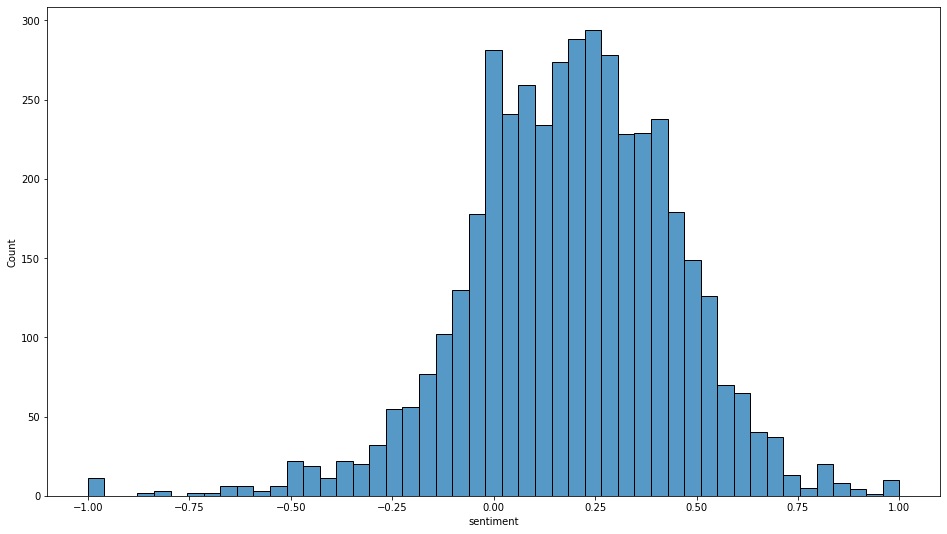

In [84]:
# Sentiment distribution
sns.histplot(data=df_sentiment, x='sentiment')

In [87]:
# Label each review into 'Positive', 'Negative', 'Neutral' according to the seats rating
df_sentiment = df_sentiment.loc[(df_sentiment['sentiment']<=-0.1) |  (df_sentiment['sentiment']>=0.1)]

df_sentiment.loc[df_sentiment['sentiment']<=-0.1, 'sentiment_binary'] = False
df_sentiment.loc[df_sentiment['sentiment']>=0.1, 'sentiment_binary'] = True

In [88]:
# Transform our data in correct format
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(df_sentiment.preprocessed_review)
y_train = list(df_sentiment.sentiment_binary)

In [89]:
# Fit logistic regression model
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [90]:
X_train

<3301x1385 sparse matrix of type '<class 'numpy.float64'>'
	with 81133 stored elements in Compressed Sparse Row format>

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


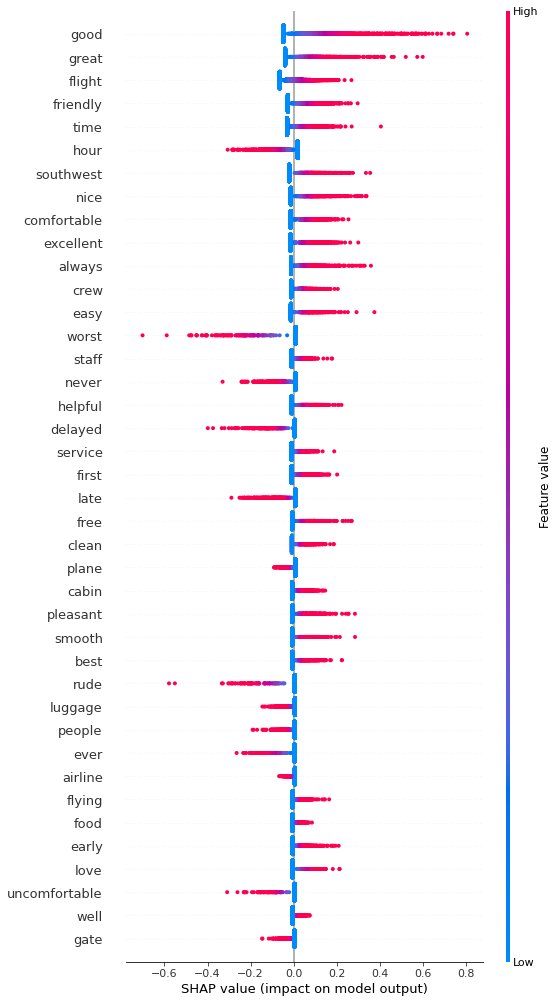

In [91]:
# Explain the model 
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_train)
X_train_array = X_train.toarray() # we need to pass a dense version for the plotting functions

# Summarize the effects of all features
shap.summary_plot(shap_values, X_train_array, feature_names=vectorizer.get_feature_names(), max_display=40)

In [96]:
# Refine the analysis by filtering out words with sentimental connotation
sentiment_word = ['good', 'great', 'friendly', 'nice', 'excellent', 'worst', 'never', 'best', 'rude', 'love', 'well']

# Add colunm with preprocessed reviews without sentimental word
df_sentiment['preprocessed_review_neutral'] = [' '.join(filter(lambda word: word not in sentiment_word, token)) 
                                           for token in df_sentiment['tokens']]

In [97]:
# Transform our data in correct format
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(df_sentiment.preprocessed_review_neutral)
y_train = list(df_sentiment.sentiment_binary)



In [98]:
# Fit logistic regression model
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


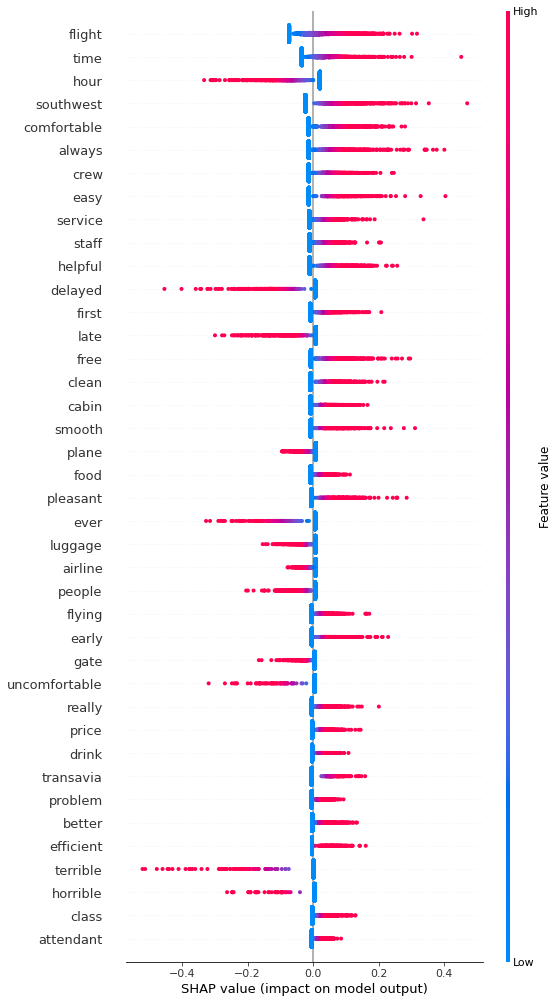

In [99]:
# Explain the model 
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_train)
X_train_array = X_train.toarray() # we need to pass a dense version for the plotting functions

# Summarize the effects of all features
shap.summary_plot(shap_values, X_train_array, feature_names=vectorizer.get_feature_names(), max_display=40)

In [100]:
# Zoom in on a specific word
def find_ngram(reviews_token, target_word, stop_words=None, ngrams_number=1, number_top_words=10):
    
    def create_ngrams(token_list, nb_elements, stop_words=None):
        """
        Create n-grams for list of tokens
        Parameters
        ----------
        token_list : list
            list of strings
        nb_elements :
            number of elements in the n-gram
        Returns
        -------
        Generator
            generator of all n-grams
        """
        if stop_words is not None:
            token_list = [token for token in token_list if token not in stop_words]
        ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
        
        # Only keep ngram with target_word
        ngrams_retained = []
        for ngram in ngrams:
            keep = False
            
            for element in ngram:
                if element==target_word:
                    keep = True
            if keep:
                ngrams_retained.append(ngram)
            
        
        return list(" ".join(ngram) for ngram in ngrams_retained)
    
    
    list_ngrams = []
    for review in reviews_token:
        ngram = create_ngrams(review, nb_elements=ngrams_number, stop_words=stop_words)
        list_ngrams += ngram
    
    counter = Counter(list_ngrams)
        
    return counter.most_common(number_top_words)

In [115]:
find_ngram(df_sentiment.loc[df_sentiment['sentiment_binary']==False].tokens, target_word='seat',
           ngrams_number=2, number_top_words=20)

[('seat front', 10),
 ('seat uncomfortable', 9),
 ('uncomfortable seat', 7),
 ('random seat', 5),
 ('seat flight', 5),
 ('front seat', 5),
 ('middle seat', 5),
 ('seat together', 4),
 ('window seat', 4),
 ('seat dirty', 4),
 ('change seat', 3),
 ('seat floor', 3),
 ('seat allocation', 3),
 ('terrible seat', 3),
 ('empty seat', 3),
 ('seat recline', 3),
 ('seat back', 3),
 ('seat staff', 3),
 ('flight seat', 3),
 ('seat taken', 3)]